In [66]:
#imports
import tensorflow as tf 
from keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import numpy as np
import itertools

# Exploratory Data Analysis

### Get Data

In [67]:
labels = pd.read_csv('./data/training_norm.csv').rename(columns={'image_id':'id'}).set_index('id')
fileNames = np.array(sorted(os.listdir('data/training_data/training_data/')))

#images data size too big needs to find way to stream data 
#relabel data 1-16 and assing them into folders for data streaming

In [68]:
im1 = plt.imread('data/training_data/training_data/1.png')
print(f'labels:\n {labels[0:5]} \
      \n\nfileNames:\n {fileNames[0:4]} \n\nImage size: {len(im1)} x {len(im1[0])}')

labels:
      angle  speed
id               
1   0.4375    0.0
2   0.8125    1.0
3   0.4375    1.0
4   0.6250    1.0
5   0.5000    0.0       

fileNames:
 ['1.png' '10.png' '100.png' '1000.png'] 

Image size: 240 x 320


### Finding mismatched entries - fileNames vs labels

In [69]:
labels_id = ['{}'.format(num) for num in labels.index.tolist()]
fileNames_id = [filename.split('.')[0] for filename in fileNames]

print(f' fileNames - labels: {list(set(fileNames_id) - set(labels_id))} \n \
labels - fileNames: {list(set(labels_id) - set(fileNames_id))}')

 fileNames - labels: ['3999', '8285', '4895', '3141', '10171'] 
 labels - fileNames: []


### Checking 'speed' and 'angle' entry values

In [70]:
a = labels['speed'].value_counts().count() #should be 2
b = labels[(labels['speed'] > 1.0) | (labels['speed'] < 0.0)]
c = labels['angle'].value_counts().count() #should be 17
d = labels[(labels['angle'] > 1.0) | (labels['angle'] < 0.0)]

print(f'speed value count:{a} \n\n{b} \n\n\n angle value count:{c} \n\n{d}')

speed value count:3 

       angle     speed
id                    
3884  0.4375  1.428571 


 angle value count:17 

Empty DataFrame
Columns: [angle, speed]
Index: []


### Checking dimensionalities

In [75]:
fileNames_test = np.array(sorted(os.listdir('data/test_data/test_data/')))
a = []
for i in fileNames_test:
    img = plt.imread(f'data/test_data/test_data/{i}')[:,:,:3]
    #print(f'{i}   1: {len(img)}   2: {len(img[0])}    3: {len(img[0][0])}')
    if len(img[0][0]) != 3:
        a.append(i)

len(a)

0

### Removing invalid entries

NOTE: indexing of 'label' requires use of its id column, which is independent of the actual index/position in the dataframe

In [22]:
invalid_png = ['4895.png', '3999.png', '8285.png', '10171.png', '3141.png', '3884.png']
invalid = [4895, 3999, 8285, 10171, 3141, 3884]

print(f'len(labels):{len(labels)}   len(fileNames):{len(fileNames)}')
labels = labels[~labels.index.isin(invalid)]
fileNames = fileNames[~np.isin(fileNames,invalid_png)]
print(f'len(labels):{len(labels)}   len(fileNames):{len(fileNames)}')

len(labels):13793   len(fileNames):13798
len(labels):13792   len(fileNames):13792


### Visualise

Using final sets of images, to ensure alignment throughout

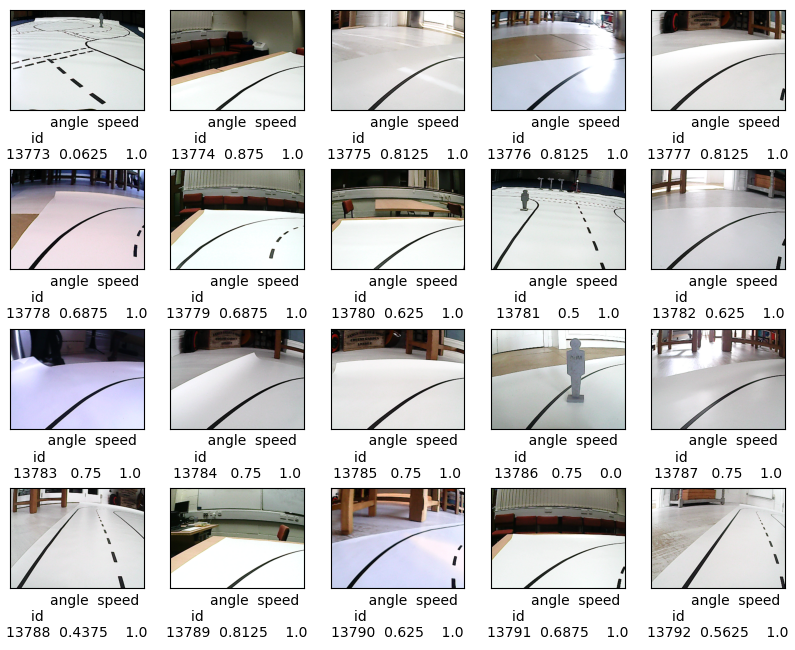

In [23]:
plt.figure(figsize=(10,10))
plt.rcParams.update({'font.size': 10})
for i in range(13773,13793):
    plt.subplot(5,5,i-13772)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    im = plt.imread(f'data/training_data/training_data/{i}.png')
    plt.imshow(im)
    plt.xlabel(labels.loc[[i]].to_string())
plt.show()

# Model

In [27]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(320, 240, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(16, activation='softmax'))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 318, 238, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 159, 119, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 157, 117, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 78, 58, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 76, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 272384)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │    17,432,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,490,000 (66.72 MB)

 Trainable params: 17,490,000 (66.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2) #!check names & outputs

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

ValueError: Found input variables with inconsistent numbers of samples: [13798, 13793]